In [1]:
import os, sys, time
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, truncnorm, foldnorm
import warnings
from time import perf_counter
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA


from farich_functions import *

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
datadir = 'data'

In [4]:
# filepath = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_no.root')
# filepath_fixed = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_fixed.root')
# filepath_fixed = os.path.join(datadir, 'fullsim_optical_10000_pi_500_1500_FARICH_35mm_no.root')
filepath_fixed = os.path.join(datadir, 'fullsim_optical_10000_pi_500_1500_FARICH_35mm_no_no_trackers.root')
filepath_low_energies = os.path.join(datadir, 'fullsim_optical_10000_pi_500_800_FARICH_35mm_no_no_trackers.root')
# filepath_monodir = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_monodir_no.root')
filepath_monodir = os.path.join(datadir, 'fullsim_optical_10000_pi_1500_monodir_FARICH_no.root')

# filepath_2pi = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_2pi_phi.root')
# filepath_prototype = os.path.join(datadir, 'farichsim_10kevt.root')
# filepath_new = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_spectre_test_3.root')

In [5]:
# file = uproot.open(filepath)
file = uproot.open(filepath_fixed)
file_low= uproot.open(filepath_low_energies)
# file = uproot.open(filepath_monodir)
# file_2pi = uproot.open(filepath_2pi)
# file_prototype = uproot.open(filepath_prototype)
# file_new = uproot.open(filepath_new)

In [6]:
plt.style.use('default')

In [7]:
# plot_cyl(file, transposed=True)

In [8]:
# np.concatenate(np.array(file['events;1']['FarichBarrelG4Hits.postStepPosition.x'].array())).shape

# Main (tmp obv)

In [9]:
def init_sipm_eff():
    pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
    t1 = []
    t2 = []
    for inedx, row in pdes_tmp.iterrows():
        t1.append(float(row['A'].split(';')[0].replace(',', '.')))
        t2.append(float(row['A'].split(';')[1].replace(',', '.')))
    PDE_wvs = np.linspace(200, 900, 128)
    PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
    sipm_eff = fix_PDE_plot(PDEs, PDE_wvs)
    return sipm_eff, PDE_wvs

In [10]:
sipm_eff, PDE_wvs = init_sipm_eff()

In [11]:
max(sipm_eff.values())

0.55414

максисмальное значение в старом моделировании - 38%

In [12]:
for key in sipm_eff.keys():
    sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

In [13]:
max(sipm_eff.values())

0.38

In [14]:
x_grid = np.arange(-3*norm_r * np.sin(np.pi / 27), 3*norm_r * np.sin(np.pi / 27), SIPM_CELL_SIZE)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

In [15]:
def init_coords(file, MAXIMUM_EVENT_GROUP_NUMBER):
    x = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.x'].array())
    y = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.y'].array())
    z = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.z'].array())
    wvs = 1239.841 / np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.energy'].array()) * 1e-9
    x3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.px'].array())
    y3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.py'].array())
    z3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.pz'].array())
    true_direction_coordinates = np.column_stack((x3, y3, z3))
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs))
    return coordinates, true_direction_coordinates

In [16]:
MAXIMUM_EVENT_GROUP_NUMBER = 9 # 13
MAXIMUM_EVENT_GROUP_NUMBER_LOW = 6

In [17]:
coordinates, true_direction_coordinates = init_coords(file, MAXIMUM_EVENT_GROUP_NUMBER)

In [18]:
coordinates_low, true_direction_coordinates_low = init_coords(file_low, MAXIMUM_EVENT_GROUP_NUMBER_LOW)

In [19]:
coordinates = np.concatenate((coordinates, coordinates_low), axis=0)
true_direction_coordinates = np.concatenate((true_direction_coordinates, true_direction_coordinates_low), axis=0)

In [20]:
# x = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.x'].array())
# y = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.y'].array())
# z = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.z'].array())
# wvs = 1239.841 / np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [21]:
# x1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.x'].array())
# y1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.y'].array())
# z1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.z'].array())
# drift_chamber_coordinates = np.column_stack((x1, y1, z1))

In [22]:
# x2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.x'].array())
# y2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.y'].array())
# z2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.z'].array())
# tpc_coordinates = np.column_stack((x2, y2, z2))

In [23]:
# x3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.px'].array())
# y3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.py'].array())
# z3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.pz'].array())
# true_direction_coordinates = np.column_stack((x3, y3, z3))

In [24]:
# for i in range(len(wvs)):
#     wvs[i] = lin_move_to_grid(wvs[i], grid[2])

In [25]:
# coordinates = np.column_stack((x, y, z, wvs))

coordinates.shape

(19996, 4)

In [26]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)

In [27]:
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)
print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(19987, 4)
(19987, 3)


In [28]:
# ev = 123
# plot_event(coordinates[ev], None, None, np.stack([np.concatenate(true_direction_coordinates[ev]), np.concatenate(true_direction_coordinates[ev] * 3000)], axis=1))
# То есть есть события, когда направление первичной частицы не попадает в кольцо. Почему?


In [29]:
sipm_sim(coordinates, sipm_eff)

In [30]:
# plot_cyl(file, coordinates, True)

In [31]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)

print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(19881, 4)
(19881, 3)


In [32]:
main_angles = rotate_lines(true_direction_coordinates)

In [33]:
intersections = find_intersections(true_direction_coordinates)

[array([0.00329075]) array([1.06504879]) array([0.96075904])]


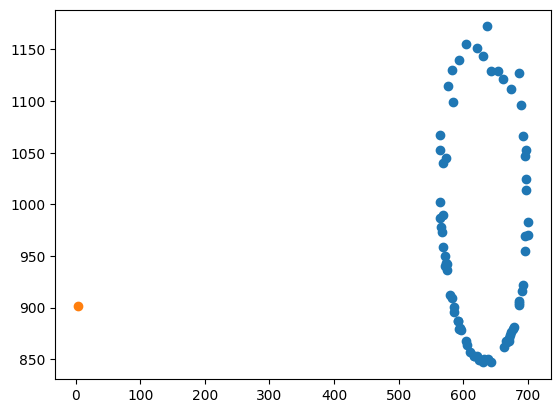

In [34]:

num = 30 # unturned events
# plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
plt.scatter(coordinates[num][0], coordinates[num][2])
plt.scatter(intersections[num][0], intersections[num][2])
print(true_direction_coordinates[num])
plt.show()

In [35]:
# plot_event(coordinates[num], drift_chamber_coordinates[num],tpc_coordinates[num] , transposed=True)

In [36]:
rotate_events(coordinates, main_angles)

In [37]:
# plot_cyl(file, coordinates)

In [38]:
move_events_to_grid(coordinates, grid)

In [39]:
# plot_cyl(file, coordinates, True)

In [40]:
# num = 2
# # plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
# plt.scatter(coordinates[num][0], coordinates[num][2])
# plt.scatter(intersections[num][0], intersections[num][2])
# plt.show()

In [41]:
r_c = (coordinates[:,0] - intersections[:,0]) ** 2 + (coordinates[:,1] - intersections[:,1]) ** 2

In [42]:
repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])

In [43]:
edf = pd.DataFrame(coordinates, columns=['x_c', 'y_c', 'z_c', 'wv_c'])
edf['r_c'] = r_c

In [44]:
unraveled_data = {col: [] for col in edf.columns}
row_indices = []

# Iterate over the DataFrame and unravel the arrays
for i, row in edf.iterrows():
    max_length = max(len(row[col]) for col in edf.columns)
    for k in range(max_length):
        row_indices.append((i, k))
        for col in edf.columns:
            if k < len(row[col]):
                unraveled_data[col].append(row[col][k])
            else:
                unraveled_data[col].append(np.nan)  # Handle cases where arrays are of different lengths

# Create a new DataFrame from the unraveled data
unraveled_df = pd.DataFrame(unraveled_data)

# Create a MultiIndex for the rows
multi_index = pd.MultiIndex.from_tuples(row_indices, names=['entry', 'subentry'])
unraveled_df.index = multi_index


In [45]:
unraveled_df['r_c'] = np.sqrt(unraveled_df.r_c)

In [46]:
edf = unraveled_df

In [47]:
edf['x_i'] = np.repeat(intersections[:,0], repeat_nums, axis=0)
edf['z_i'] = np.repeat(intersections[:,2], repeat_nums, axis=0)

In [48]:
x = y = z = x3 = y3 = z3 = unraveled_data = row_indices = main_angles = intersections = wvs = coordinates = file = coordinates_low = file_low = 0

In [49]:
# edf[edf.wv_c < 1]

In [50]:
# min_r_c = []
# for entry, subentry in edf[edf.wv_c < 1].r_c.groupby(level=0):
#     # print(min(subentry))
#     min_r_c.append(min(subentry))

In [51]:
# min_r_c = np.array(min_r_c)

In [52]:
# min_r_c.shape

In [53]:
/

()

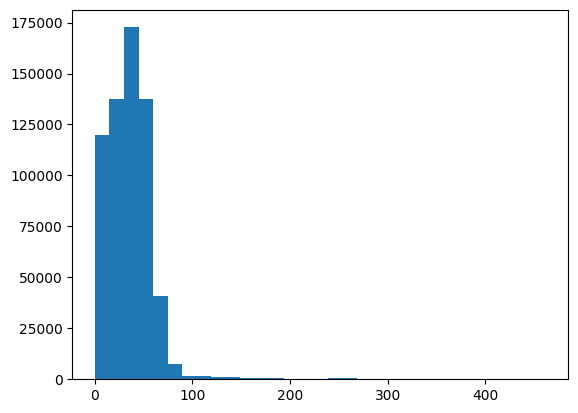

In [54]:
plt.hist(edf[edf.r_c<1000].r_c, bins='doane')
plt.show()

In [55]:
bdf = pd.DataFrame()
edf['t_c'] = np.zeros(edf.shape[0])
edf.drop('y_c', axis=1, inplace=True)
edf.rename(columns={'z_c': 'y_c', 'z_i': 'y_i'}, inplace=True)
edf['z_c'] = np.zeros(edf.shape[0]) + 2000
edf['true_p'] = np.repeat(np.linalg.norm(true_direction_coordinates.astype('float'), axis=1)*1000, repeat_nums, axis=0)
edf['beta'] = edf.true_p / np.sqrt(139.57 ** 2 + edf.true_p ** 2)
edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,0], repeat_nums, axis=0)
edf['ny_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,2], repeat_nums, axis=0)
edf['nz_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,1], repeat_nums, axis=0)

C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\1986587013.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['true_p'] = np.repeat(np.linalg.norm(true_direction_coordinates.astype('float'), axis=1)*1000, repeat_nums, axis=0)
C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\1986587013.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\1986587013.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a 

In [56]:
true_direction_coordinates = repeat_nums = true_direction_coordinates_low = 0

In [57]:
edf.shape[0]

626199

In [58]:
idf = pd.DataFrame()
idf['W'] = [35.]
# idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [205.] # 200
idf['n_mean'] = [1.04511]
# 
# idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]

In [59]:
idf

,W,zdis,distance,n_mean,pixel_size
0,35.0,800.0,205.0,1.04511,3.16


In [60]:
edf = applySpaceCut(edf)

In [61]:
planeRecalculation(edf, idf)

Z:\Prog\FARICH\farich_functions.py:513: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha = (float(dist)) / N[:, 2]
Z:\Prog\FARICH\farich_functions.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf["t_c"] = edf["t_c"] + np.sign(R_new[:, 2] - R[:, 2]) * t_dif
Z:\Prog\FARICH\farich_functions.py:528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf["recalculated_x"] = R_new[:, 0]
Z:\Prog\FARICH\farich_

In [62]:
edf['x_p'] = np.zeros(edf.shape[0])
edf['y_p'] = np.zeros(edf.shape[0])
edf['z_p'] = np.zeros(edf.shape[0])


C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\210028248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['x_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\210028248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['y_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\210028248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [63]:
planeRotation(edf)

Z:\Prog\FARICH\farich_functions.py:571: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf["rotated_x"] = rotated_R[:, 0]
Z:\Prog\FARICH\farich_functions.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf["rotated_y"] = rotated_R[:, 1]
Z:\Prog\FARICH\farich_functions.py:573: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [64]:
edf = applySecondSpaceCut(edf)

In [65]:
bdf = pd.DataFrame()
edf_to_bdf(edf.r_c.groupby(level=0).transform('mean'), bdf)
bdf.rename(columns={'r_c': 'r_c_mean'}, inplace=True)
edf_to_bdf(edf.r_c.groupby(level=0).transform('std'), bdf)
bdf.rename(columns={'r_c': 'r_c_std'}, inplace=True)
edf_to_bdf(edf.r_c.groupby(level=0).transform(lambda x: x.max() - x.min()), bdf)
bdf.rename(columns={'r_c': 'r_c_width'}, inplace=True)
edf_to_bdf(edf.true_p, bdf)
bdf.rename(columns={'true_p': 'momentum'}, inplace=True)

In [66]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0         112.960131  142.24  354.330709  41.720917  71.239214   
      1          99.520131  148.96  486.614173  28.280917  71.239214   
      2         123.040131  128.80  376.377953  51.800917  71.239214   
      3          49.120131   54.88  503.149606  22.119083  71.239214   
      4          59.200131   54.88  508.661417  12.039083  71.239214   
...                    ...     ...         ...        ...        ...   
19880 8          -7.999869 -334.88  348.818898  10.236974   2.237105   
      9          32.320131 -365.12  580.314961  30.083026   2.237105   
      10         28.960131 -351.68  348.818898  26.723026   2.237105   
      11        -14.719869 -395.36  530.708661  16.956974   2.237105   
      12        -18.079869 -344.96  381.889764  20.316974   2.237105   

                       y_i       t_c     z_c       true_p      beta  ...  z_p  \
entry subentry                                                       ...        
0     0         102.379707 -0.023385  2000.0  1408.464406  0.995126  ...  0.0   
      1         102.379707 -0.022493  2000.0  1408.464406  0.995126  ...  0.0   
      2         102.379707 -0.021214  2000.0  1408.464406  0.995126  ...  0.0   
      3         102.379707  0.021550  2000.0  1408.464406  0.995126  ...  0.0   
      4         102.379707  0.019134  2000.0  1408.464406  0.995126  ...  0.0   
...                    ...       ...     ...          ...       ...  ...  ...   
19880 8        -363.199793  0.034009  2000.0   511.674644  0.964753  ...  0.0   
      9        -363.199793 -0.002503  2000.0   511.674644  0.964753  ...  0.0   
      10       -363.199793  0.013547  2000.0   511.674644  0.964753  ...  0.0   
      11       -363.199793 -0.037831  2000.0   511.674644  0.964753  ...  0.0   
      12       -363.199793  0.021948  2000.0   511.674644  0.964753  ...  0.0   

                rotated_x   rotated_y    rotated_z  rotated_x_i  rotated_y_i  \
entry subentry                                                                 
0     0        -29.046061  -61.721871  2000.059575   -70.691475  -101.592538   
      1        -42.406714  -55.040504  2000.059575   -70.691475  -101.592538   
      2        -19.013148  -75.090711  2000.059575   -70.691475  -101.592538   
      3        -93.089516 -149.578954  2000.059575   -70.691475  -101.592538   
      4        -82.929370 -149.524410  2000.059575   -70.691475  -101.592538   
...                   ...         ...          ...          ...          ...   
19880 8        -12.435423  371.165704  2003.839929    -2.102706   341.379863   
      9         27.961818  339.371053  2003.839929    -2.102706   341.379863   
      10        24.708979  353.425544  2003.839929    -2.102706   341.379863   
      11       -18.889273  308.171744  2003.839929    -2.102706   341.379863   
      12       -22.537476  360.509342  2003.839929    -2.102706   341.379863   

                rotated_z_i  rotated_nx_p  rotated_ny_p  rotated_nz_p  
entry subentry                                                         
0     0         2000.059575     -0.035277     -0.050698      0.998091  
      1         2000.059575     -0.035277     -0.050698      0.998091  
      2         2000.059575     -0.035277     -0.050698      0.998091  
      3         2000.059575     -0.035277     -0.050698      0.998091  
      4         2000.059575     -0.035277     -0.050698      0.998091  
...                     ...           ...           ...           ...  
19880 8         2003.839929     -0.001034      0.167943      0.985796  
      9         2003.839929     -0.001034      0.167943      0.985796  
      10        2003.839929     -0.001034      0.167943      0.985796  
      11        2003.839929     -0.001034      0.167943      0.985796  
      12        2003.839929     -0.001034      0.167943      0.985796  

[620733 rows x 28 columns]

In [67]:
bdf.isna().sum()

r_c_mean      0
r_c_std      21
r_c_width     0
momentum      0
dtype: int64

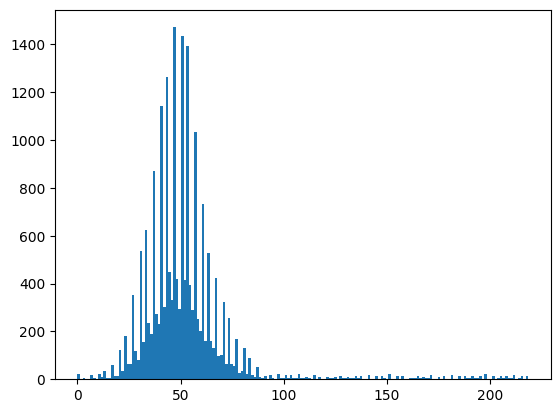

In [68]:
plt.hist(bdf[bdf.r_c_width < 1000].r_c_width, bins='auto')
plt.show()

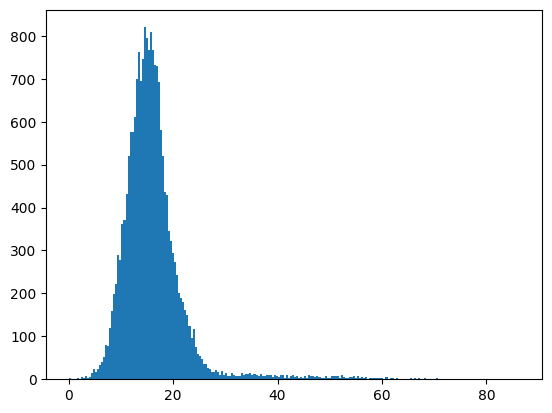

In [69]:
plt.hist(bdf[bdf.r_c_std < 1000].r_c_std, bins='auto')
plt.show()

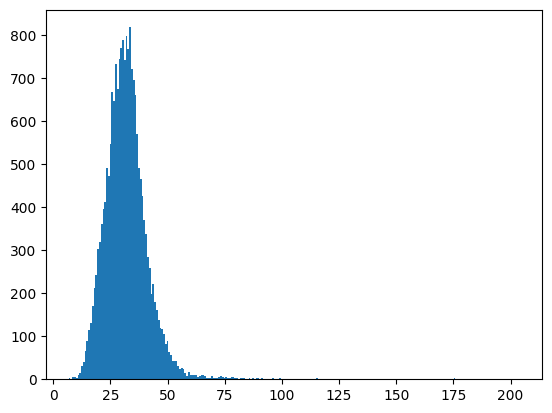

In [70]:
plt.hist(bdf[bdf.r_c_mean < 1000].r_c_mean, bins='auto')
plt.show()

In [71]:
# np.tan(1 / (edf.beta.iloc[0] * idf.n_mean)) 

In [72]:
# idf.W * np.tan(1/(idf.n_mean * edf.beta.iloc[0]))

In [73]:
# num = 7
# event = edf.loc[num]
# plt.scatter(event.rotated_x, event.rotated_y)
# plt.scatter(event.rotated_x_i, event.rotated_y_i)
# plt.show()

In [74]:
primaryDirectionRecalculation(edf)

In [75]:
edf['rotated_r_c'] = np.sqrt((edf['rotated_x_i'] - edf['rotated_x']) ** 2 + (edf['rotated_y_i'] - edf['rotated_y']) ** 2)
edf['signal'] = np.ones(edf.shape[0])

In [76]:
recoAngles(edf, idf)

Z:\Prog\FARICH\farich_functions.py:646: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dist = float(idf["distance"])
Z:\Prog\FARICH\farich_functions.py:649: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = float(idf["W"])
Z:\Prog\FARICH\farich_functions.py:652: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rad_pos = float(idf["zdis"])


In [77]:
recoAngles(edf, idf, rotation_mode=True)

Z:\Prog\FARICH\farich_functions.py:646: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dist = float(idf["distance"])
Z:\Prog\FARICH\farich_functions.py:649: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = float(idf["W"])
Z:\Prog\FARICH\farich_functions.py:652: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rad_pos = float(idf["zdis"])
Z:\Prog\FARICH\farich_functions.py:673: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  n_mean = float(idf["n_mean"])


In [78]:
calculateSignalCounts(edf, bdf)

In [142]:
def exp_like(X, a, b):
    return a * np.exp(b * X)
def pol2_exp_like(X, a0, a1, a2, b0, b1, b2):
    r, theta = X
    return exp_like(r, a0 + a1 * theta + a2 * theta ** 2, b0 + b0 * theta + b1 * theta ** 2)
def pol3(X, p0, p1, p2, p3):
    return p0 + p1 * X + p2 * X ** 2 + p3 * X ** 3
def lin(X, a, b):
    return a * X + b
def pol2_lin(X, a0, a1, a2, b0, b1, b2):
    r, theta = X
    return lin(r, a0 + a1 * theta + a2 * theta ** 2, b0 + b1 * theta + b2 * theta ** 2)
def pol2_pol2(X, a0, a1, a2, b0, b1, b2, c0, c1, c2):
    r, theta = X
    return pol2(r, a0 + a1 * theta + a2 * theta ** 2, b0 + b1 * theta + b2 * theta ** 2, c0 + c1 * theta + c2 * theta ** 2)

In [143]:
def calibration(edf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', t_window_width=2,
                        r_width_factor=2, t_width_factor=8, full_width_t_hist = False, weighed=True, deg_lim=False, param_fit=False, calibration_func=pol, param_calibration_func=d3pol2, 
                num_of_calibration_params=3, num_of_param_fit_params=3, target_variable = 'momentum', target_angle = 'theta_p', num_of_theta_intervals=11, p0=(100, 1, 100), p0_c=(1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)):  
  to_return_unbinned = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_theta_intervals - 1, num_of_calibration_params), 0.)

  errs_tmp = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_theta_intervals - 1, num_of_calibration_params), 0.)
  fit_params = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_calibration_params, num_of_param_fit_params), 0.)
  fit_params = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), num_of_calibration_params * num_of_param_fit_params), 0.)

  
  
  dir_to_save = f"{'weighed' if weighed else 'unweighed'}_rw={step}_tw={t_window_width}_rs={r_width_factor}_ts={t_width_factor}"
  if not os.path.exists(os.path.join('calibrations_barrel', dir_to_save)):
    os.mkdir(os.path.join('calibrations_barrel', dir_to_save))
      
      
  for r_sigms in range(*avg_sigmas):
    fig, axs = plt.subplots(num_of_theta_intervals - 1, np.ptp(avg_t_sigmas), figsize=(16 * np.ptp(avg_t_sigmas), 9 * (num_of_theta_intervals - 1)))
    for t_sigms in range(*avg_t_sigmas):
      chosen_column = f'unfixed_calculated_r_2d_{r_sigms}_rsigms_{t_sigms}_tsigms'

      calibration_loop(bdf, chosen_column, r_sigms, t_sigms, num_of_theta_intervals, to_return_unbinned, errs_tmp, fig, axs, avg_sigmas, avg_t_sigmas, target_variable, target_angle, calibration_func, p0)
      if param_fit:
        param_fit_calibration(bdf, chosen_column, r_sigms, t_sigms, avg_sigmas, avg_t_sigmas, fit_params, num_of_calibration_params, num_of_param_fit_params, target_variable, target_angle, param_calibration_func, p0_c=p0_c)   
    save_calibration_plot(fig, dir_to_save, deg_lim, r_sigms, avg_t_sigmas)        
      
  if param_fit:
    return fit_params, errs_tmp
  return to_return_unbinned, errs_tmp
# cal_arr = np.array(calibration(edf, bdf, avg_sigmas=(1, 5), avg_t_sigmas=(1, 5))) # add r and t calibr - done

C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\4046434055.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  def calibration(edf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', t_window_width=2,


In [148]:
def rSlidingWindow(edf: pd.DataFrame, idf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', cal_arr=False, t_window_width=2,
                        r_width_factor=2, t_width_factor=8, full_width_t_hist = True, num_of_groups=5, weighed=True, deg_lim=False, param_fit=False, 
                   calibration_func=pol, param_calibration_func=d3pol2, num_of_calibration_params=3, num_of_param_fit_params=3, target_variable='beta', target_angle='cos_theta_p', num_of_theta_intervals=11, p0=(100, 1, 100), p0_c=(1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)):
  rSlidingWindowIntro(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, num_of_groups=num_of_groups)
  rSlidingWindowLoop1(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, full_width_t_hist=full_width_t_hist, weighed=weighed)
  bdf.dropna(subset=[f'unfixed_calculated_r_2d_{avg_sigmas[0]}_rsigms_4_tsigms'], inplace=True)
  edf.dropna(subset=[f'unfixed_calculated_r_2d_{avg_sigmas[0]}_rsigms_4_tsigms'], inplace=True)
  if cal_arr is False:
    cal_arr, errs = calibration(edf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, step=step, t_window_width=t_window_width,
                                   r_width_factor=r_width_factor, t_width_factor=t_width_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit, calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params, target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c)

  rSlidingWindowLoop2(edf, idf, bdf, avg_sigmas, avg_t_sigmas, step=step, method=method, cal_arr=cal_arr, t_window_width=t_window_width,
                      r_width_factor=r_width_factor, t_width_factor=t_width_factor, param_fit=param_fit, calibration_func=calibration_func, param_calibration_func=param_calibration_func, target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals)
  return cal_arr, errs

C:\Users\BRINE\AppData\Local\Temp\ipykernel_12944\3305970447.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  def rSlidingWindow(edf: pd.DataFrame, idf: pd.DataFrame, bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, step=float(idf.pixel_size), method='N/r', cal_arr=False, t_window_width=2,


In [149]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
r_width = float(idf.pixel_size.iloc[0]) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = True # WORKS

calibration_func = pol2 # pol
param_calibration_func = pol2_pol2 # d3pol2
p0 =  (.01, 1000, 1000)
p0_c =  (1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)
num_of_calibration_params = 3 # 3
num_of_param_fit_params = 3 # for param fit both prev and this number are important, cal_func as well, therefore p0 and p0_C
target_variable = 'beta'
target_angle = 'theta_p'
num_of_theta_intervals = 11 # 11


# sample_size = 12
cal_arr = False
errs = False

beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []

In [150]:
cal_arr, errs = rSlidingWindow(edf, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, num_of_groups=num_of_groups,
                               step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit, 
                         calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params, 
                         target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c)

[ 9.53620585e-01 -4.59498199e-02  1.20054859e-01  3.71363181e-04
  1.87536856e-03 -5.30160878e-03  8.61241101e-06 -1.89973889e-05
  4.23042426e-05]
0


need to run twice. To remove broken events?

In [151]:
cal_arr

array([[[ 9.53620585e-01, -4.59498199e-02,  1.20054859e-01,
          3.71363181e-04,  1.87536856e-03, -5.30160878e-03,
          8.61241101e-06, -1.89973889e-05,  4.23042426e-05]]])

In [152]:
errs

array([[[[1.65229093e-03, 8.62514605e-05, 1.10340317e-06],
         [1.32972178e-03, 6.81027278e-05, 8.56256260e-07],
         [1.30763020e-03, 6.79014123e-05, 8.61237315e-07],
         [1.43850655e-03, 7.32713479e-05, 9.12044565e-07],
         [1.36807048e-03, 6.64687887e-05, 7.91648828e-07],
         [1.41952832e-03, 6.65821629e-05, 7.62335372e-07],
         [1.46336278e-03, 6.44760918e-05, 6.94944291e-07],
         [1.32451405e-03, 5.51705044e-05, 5.60006239e-07],
         [1.29784604e-03, 5.06304245e-05, 4.81632439e-07],
         [2.13789777e-03, 7.93205397e-05, 7.18417949e-07]]]])

In [153]:
((bdf.beta - bdf.beta_from_calc_r_4_rsigms_4_tsigms) ** 2 / bdf.beta_from_calc_r_4_rsigms_4_tsigms).sum() / num_of_calibration_params # chi2

0.06197587597776658

0.06363089185270614 - до обрезки
0.07350276021667147 - после

пока что pol2 по качеству хуже pol

pol2_pol2 лучше чем pol, но на 10 градусах немного хуже

In [87]:
beta_on_grid = lin_move_to_grid(np.array(bdf.beta), np.linspace(min(bdf.beta), max(bdf.beta), 100))
calc_beta_on_grid = lin_move_to_grid(np.array(bdf.beta_from_calc_r_4_rsigms_4_tsigms), np.linspace(min(bdf.beta), max(bdf.beta), 100))

((beta_on_grid - calc_beta_on_grid) ** 2 / calc_beta_on_grid).sum() / num_of_calibration_params

0.6422055251002917

In [88]:
np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1)

array([0.00234133, 0.1994399 , 0.39653847, 0.59363703, 0.7907356 ])

In [89]:
cal_arr[0][0][:, 0]

array([0.01043709, 0.96026065, 0.95902324, 0.96691566, 0.97009287])

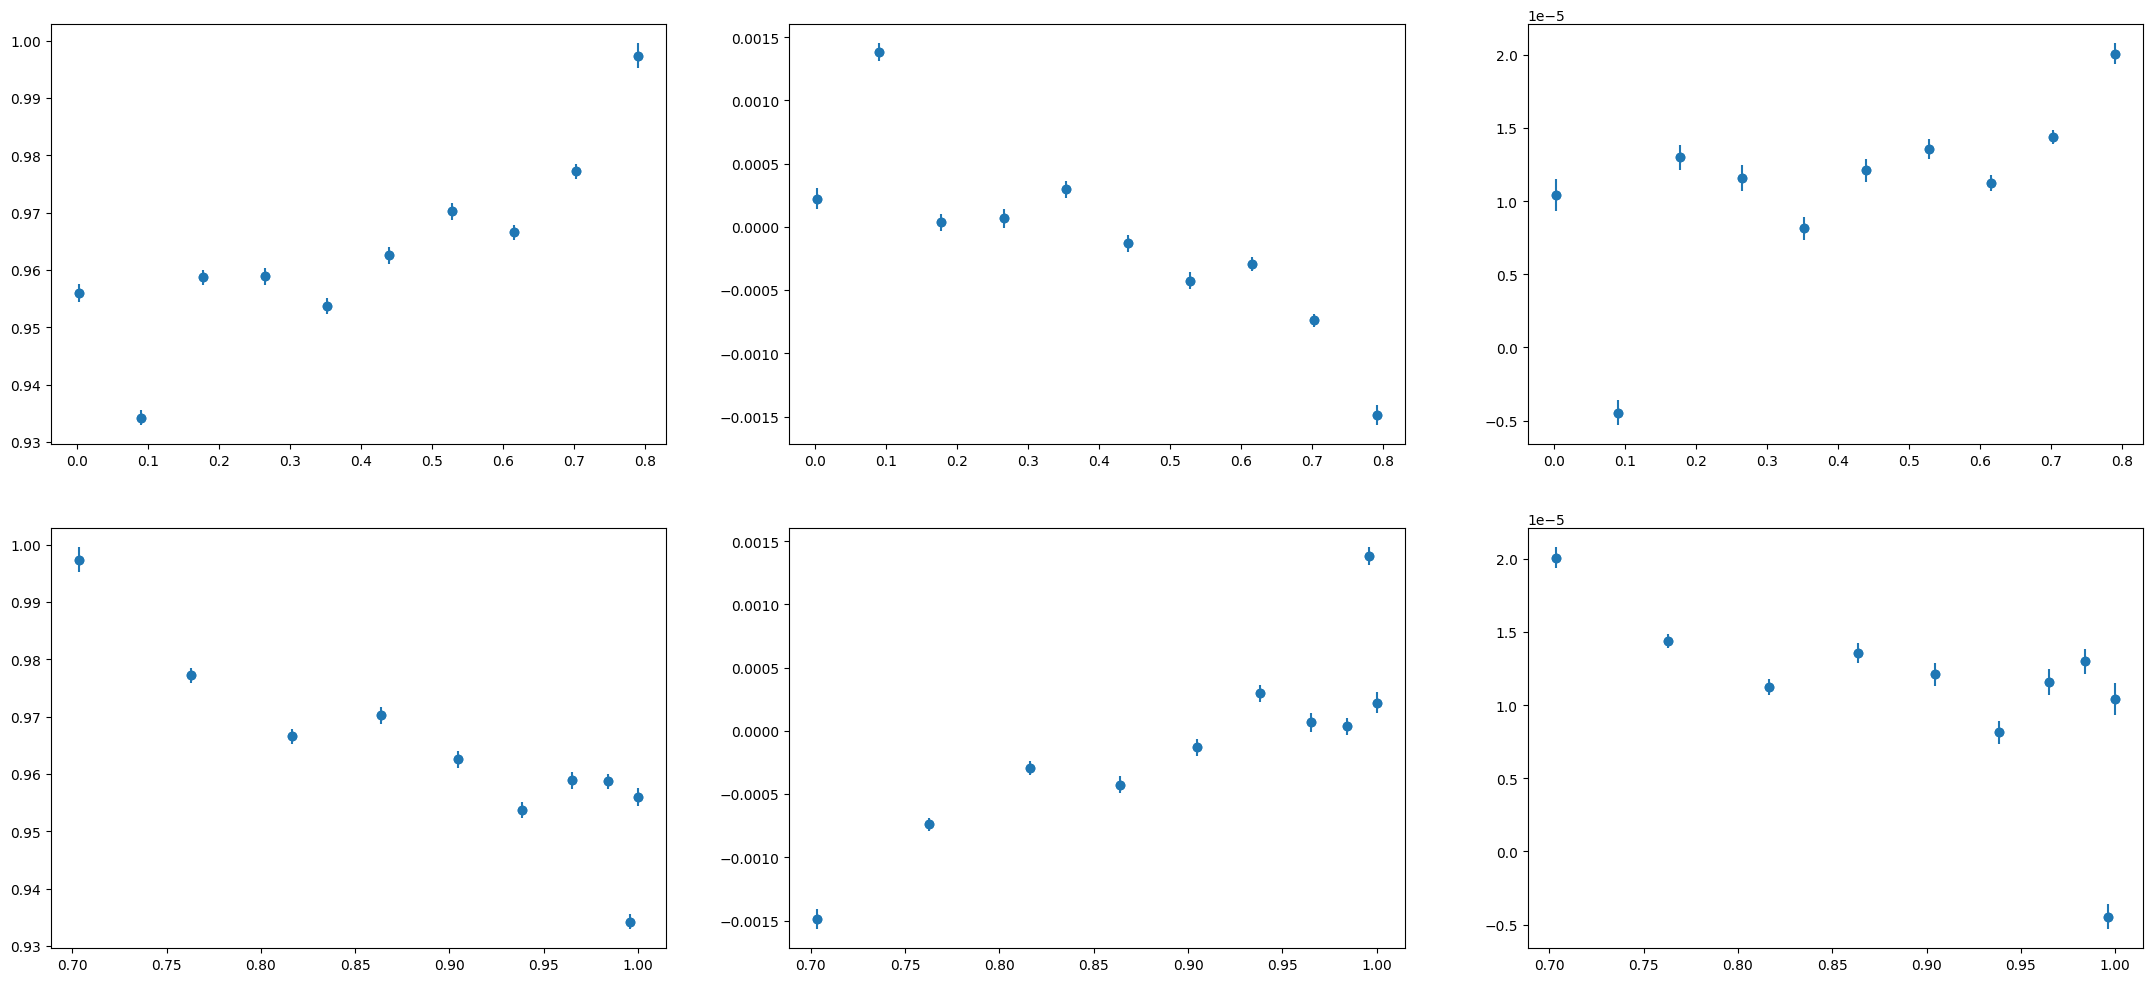

In [125]:
plt.subplots(2, 3, figsize=(27, 12))
plt.subplot(2, 3, 1)
plt.scatter(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1), cal_arr[0][0][:, 0])
plt.errorbar(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1), cal_arr[0][0][:, 0], yerr=errs[0][0][:, 0], fmt='o')
plt.subplot(2, 3, 2)
plt.scatter(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1), cal_arr[0][0][:, 1])
plt.errorbar(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1), cal_arr[0][0][:, 1], yerr=errs[0][0][:, 1], fmt='o')
plt.subplot(2, 3, 3)
plt.scatter(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1), cal_arr[0][0][:, 2])
plt.errorbar(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1), cal_arr[0][0][:, 2], yerr=errs[0][0][:, 2], fmt='o')
plt.subplot(2, 3, 4)
plt.scatter(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1)), cal_arr[0][0][:, 0])
plt.errorbar(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1)), cal_arr[0][0][:, 0], yerr=errs[0][0][:, 0], fmt='o')
plt.subplot(2, 3, 5)
plt.scatter(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1)), cal_arr[0][0][:, 1])
plt.errorbar(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1)), cal_arr[0][0][:, 1], yerr=errs[0][0][:, 1], fmt='o')
plt.subplot(2, 3, 6)
plt.scatter(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1)), cal_arr[0][0][:, 2])
plt.errorbar(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p), num=num_of_theta_intervals-1)), cal_arr[0][0][:, 2], yerr=errs[0][0][:, 2], fmt='o')
plt.show()

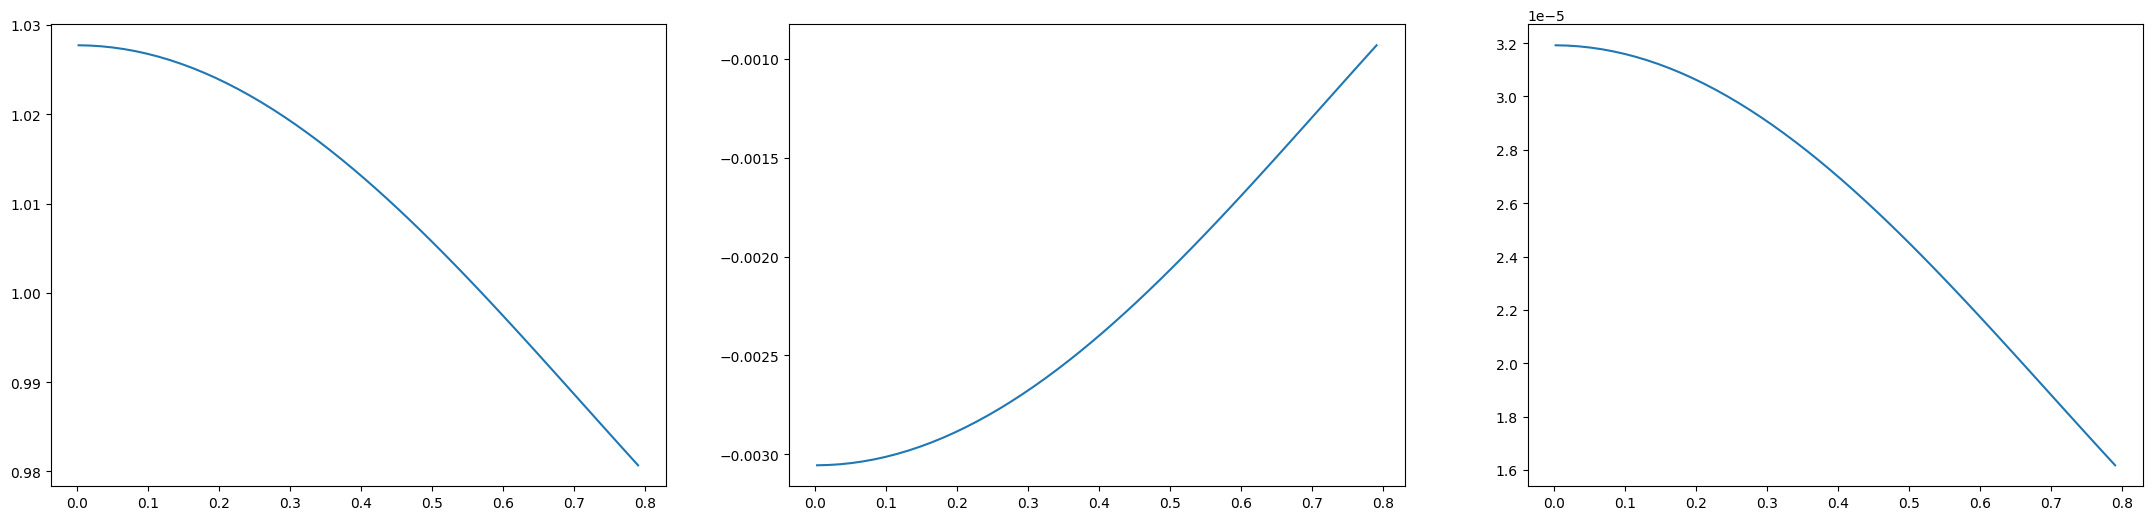

In [155]:
plt.subplots(1, 3, figsize=(27, 6))

plt.subplot(1, 3, 1)
plt.plot((np.linspace(min(bdf.theta_p), max(bdf.theta_p))), pol2(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p))), *cal_arr[0][0][0:3]))
# plt.ylim((0.945, 0.964))
plt.subplot(1, 3, 2)
plt.plot((np.linspace(min(bdf.theta_p), max(bdf.theta_p))), pol2(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p))), *cal_arr[0][0][3:6]))
# plt.ylim((-27, 12))
plt.subplot(1, 3, 3)
plt.plot((np.linspace(min(bdf.theta_p), max(bdf.theta_p))), pol2(np.cos(np.linspace(min(bdf.theta_p), max(bdf.theta_p))), *cal_arr[0][0][6:9]))
# plt.ylim((300, 390))
plt.show()

In [91]:
bdf

,r_c_mean,r_c_std,r_c_width,momentum,signal_counts,beta_group,theta_p,cos_theta_p,beta,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms
0,36.032869,14.829350,53.201834,1408.464406,45.0,10.0,0.124085,0.992311,0.995126,50.457499,0.993111,-0.002016,-0.202541
1,33.720610,19.296941,60.480000,932.768102,41.0,8.0,0.454187,0.898618,0.988990,52.863912,0.990685,0.001695,0.171389
2,78.979862,53.852844,206.717462,770.366650,78.0,7.0,0.761376,0.723888,0.983981,63.362033,0.985608,0.001626,0.165278
3,34.302304,13.381021,44.434728,868.738138,29.0,8.0,0.117904,0.993057,0.987339,44.531923,0.986898,-0.000441,-0.044628
4,32.248691,14.975025,52.153319,891.133356,56.0,8.0,0.307330,0.953145,0.987956,46.579741,0.987809,-0.000147,-0.014847
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19864,36.056951,17.700165,59.981424,772.556603,41.0,7.0,0.668863,0.784528,0.984070,58.181292,NaN,NaN,NaN
19865,20.257585,7.700895,23.246762,511.352902,7.0,1.0,0.370776,0.932046,0.964711,25.747498,NaN,NaN,NaN
19866,12.572937,4.751758,6.720000,509.515672,2.0,1.0,0.453877,0.898754,0.964470,20.018626,NaN,NaN,NaN
19867,29.278834,14.832365,45.970471,787.607792,29.0,7.0,0.212217,0.977566,0.984659,43.190392,NaN,NaN,NaN


In [92]:
edf

x_c     y_c        wv_c        r_c       x_i  \
entry subentry                                                        
0     0         112.960131  142.24  354.330709  57.090597  71.59541   
      1          99.520131  148.96  486.614173  53.871022  71.59541   
      2         123.040131  128.80  376.377953  57.600384  71.59541   
      3          49.120131   54.88  503.149606  53.011814  71.59541   
      4          59.200131   54.88  508.661417  49.585857  71.59541   
...                    ...     ...         ...        ...       ...   
19880 8          -7.999869 -334.88  348.818898  31.830658   2.24829   
      9          32.320131 -365.12  580.314961  30.072021   2.24829   
      10         28.960131 -351.68  348.818898  29.855749   2.24829   
      11        -14.719869 -395.36  530.708661  34.766210   2.24829   
      12        -18.079869 -344.96  381.889764  28.556416   2.24829   

                       y_i       t_c     z_c       true_p      beta  ...  \
entry subentry                                                       ...   
0     0         102.891605 -0.023385  2000.0  1408.464406  0.995126  ...   
      1         102.891605 -0.022493  2000.0  1408.464406  0.995126  ...   
      2         102.891605 -0.021214  2000.0  1408.464406  0.995126  ...   
      3         102.891605  0.021550  2000.0  1408.464406  0.995126  ...   
      4         102.891605  0.019134  2000.0  1408.464406  0.995126  ...   
...                    ...       ...     ...          ...       ...  ...   
19880 8        -365.015792  0.034009  2000.0   511.674644  0.964753  ...   
      9        -365.015792 -0.002503  2000.0   511.674644  0.964753  ...   
      10       -365.015792  0.013547  2000.0   511.674644  0.964753  ...   
      11       -365.015792 -0.037831  2000.0   511.674644  0.964753  ...   
      12       -365.015792  0.021948  2000.0   511.674644  0.964753  ...   

                mean_rotated_r_c  dist_from_mean_rotated_r_c  \
entry subentry                                                 
0     0                54.010725                    3.643509   
      1                54.010725                    0.460548   
      2                54.010725                    4.066778   
      3                54.010725                    1.054438   
      4                54.010725                    4.541235   
...                          ...                         ...   
19880 8                28.987048                    2.540105   
      9                28.987048                    1.144513   
      10               28.987048                    0.406232   
      11               28.987048                    8.222736   
      12               28.987048                    0.995678   

                rotated_r_c_sigm  beta_group  slice_counts_4_sigms  \
entry subentry                                                       
0     0                 2.193102        10.0              0.084765   
      1                 2.193102        10.0              0.511198   
      2                 2.193102        10.0              0.084765   
      3                 2.193102        10.0              0.511198   
      4                 2.193102        10.0              0.237342   
...                          ...         ...                   ...   
19880 8                 5.848032         1.0              0.158228   
      9                 5.848032         1.0              0.158228   
      10                5.848032         1.0              0.203436   
      11                5.848032         1.0              0.052743   
      12                5.848032         1.0              0.203436   

                unfixed_calculated_r_2d_4_rsigms_4_tsigms  cos_theta_p  \
entry subentry                                                           
0     0                                         50.457499     0.992311   
      1                                         50.457499     0.992311   
      2                                         50.457499     0.992311

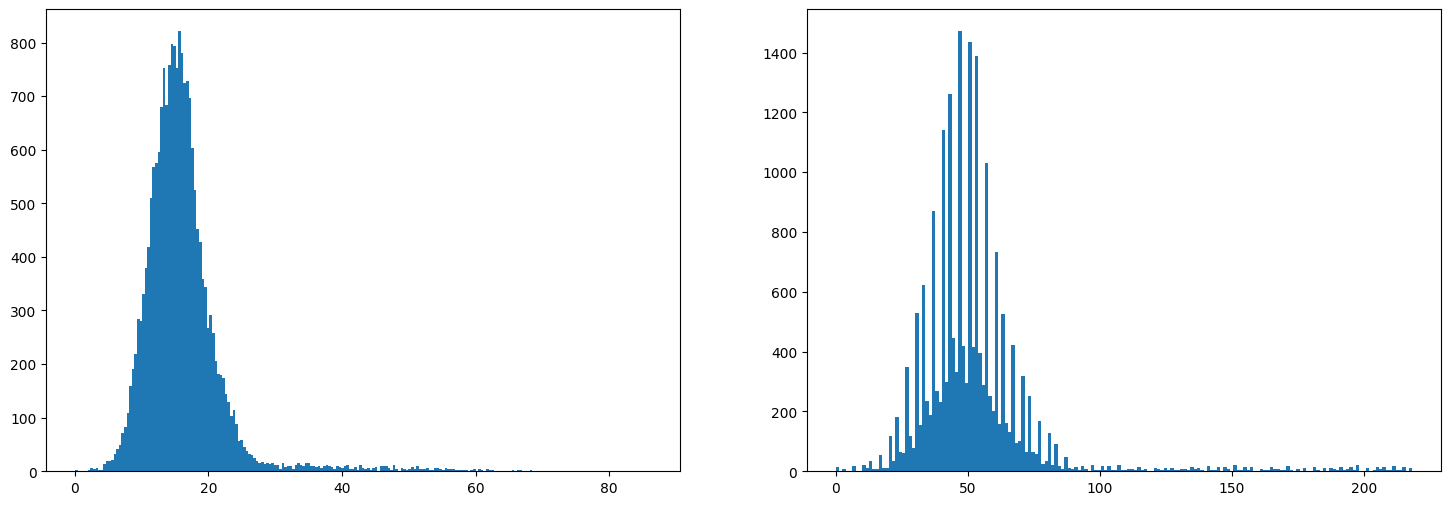

In [93]:
plt.subplots(1, 2, figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(bdf.r_c_std, bins='auto')
plt.subplot(1, 2, 2)
plt.hist(bdf.r_c_width, bins='auto')
plt.show()

In [94]:
np.tan(np.arccos(1 / (idf.n_mean * bdf.iloc[0].beta))) * 40

0    11.428647
Name: n_mean, dtype: float64

In [95]:
np.sin(np.arccos(1 / (idf.n_mean * bdf.iloc[0].beta))) ** 2 * 90 * 40

0    271.701444
Name: n_mean, dtype: float64

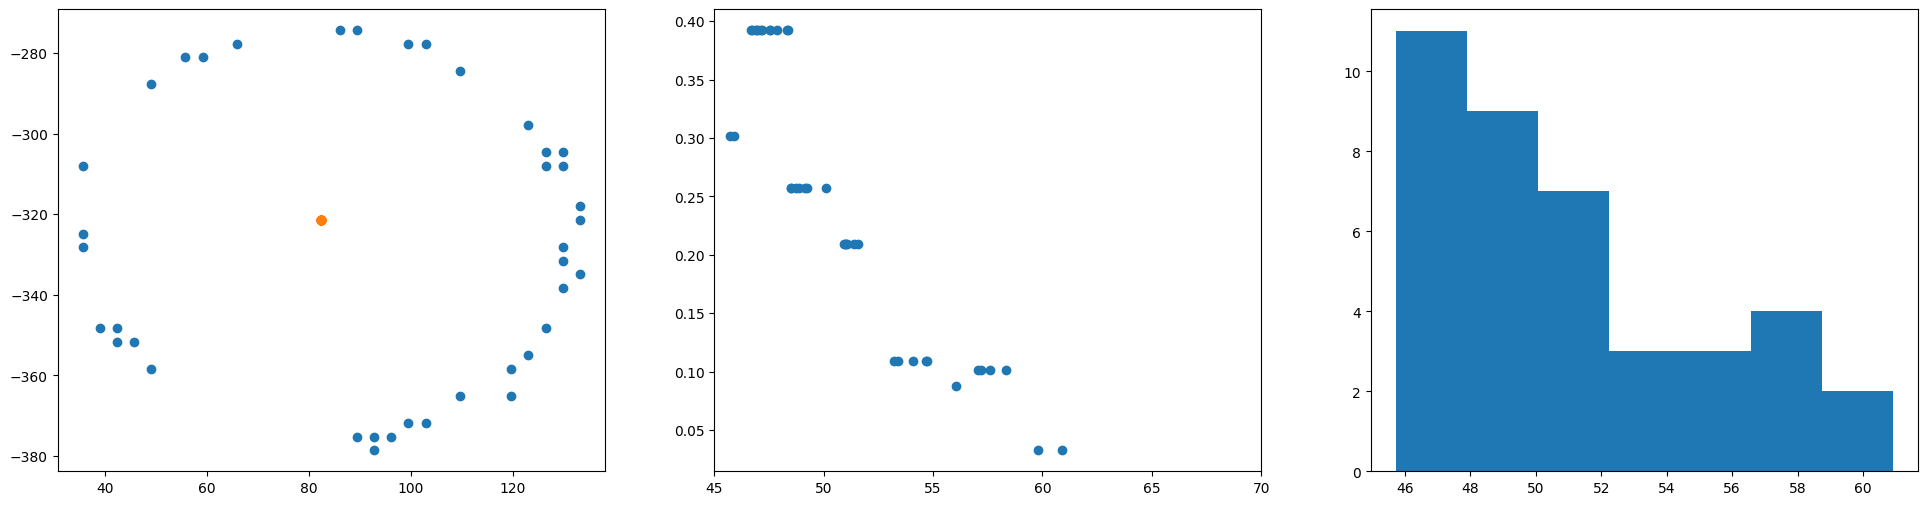

In [96]:
event = edf.loc[12]
plt.subplots(1, 3, figsize=(24, 6))
plt.subplot(1, 3, 1)
plt.scatter(event.x_c, event.y_c)
plt.scatter(event.x_i, event.y_i)
# plt.xlim((-70, 70))
# plt.ylim((-70, 70))
plt.subplot(1, 3, 2)
plt.scatter(event.rotated_r_c, event.slice_counts_4_sigms)
plt.xlim((45, 70))
plt.subplot(1, 3, 3)
plt.hist(event.rotated_r_c, bins='auto')
plt.show()

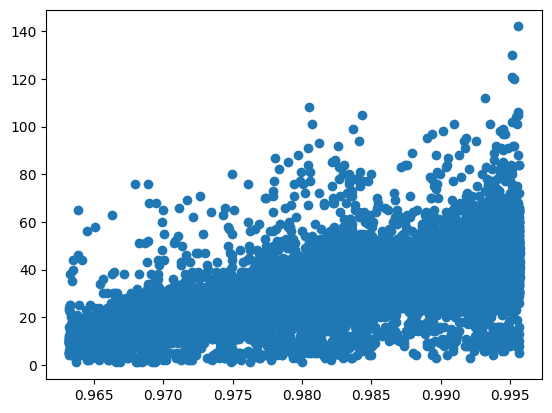

In [97]:
plt.scatter(bdf.beta, bdf.signal_counts)
plt.show()

In [98]:
event

,x_c,y_c,wv_c,r_c,x_i,y_i,t_c,z_c,true_p,beta,...,mean_rotated_r_c,dist_from_mean_rotated_r_c,rotated_r_c_sigm,beta_group,slice_counts_4_sigms,unfixed_calculated_r_2d_4_rsigms_4_tsigms,cos_theta_p,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms
subentry,,,,,,,,,,,,,,,,,,,,,
0,49.120131,-287.84,503.149606,47.261460,82.445773,-321.351895,0.042808,2000.0,801.335527,0.985169,...,50.947511,3.396695,4.193079,7.0,0.392130,45.427425,0.949598,0.982929,-0.00224,-0.227343
1,92.800131,-375.20,387.401575,54.834579,82.445773,-321.351895,-0.060419,2000.0,801.335527,0.985169,...,50.947511,6.650185,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343
2,126.400131,-308.00,453.543307,45.937552,82.445773,-321.351895,0.000390,2000.0,801.335527,0.985169,...,50.947511,5.047912,4.193079,7.0,0.302071,45.427425,0.949598,0.982929,-0.00224,-0.227343
3,45.760131,-351.68,492.125984,47.598638,82.445773,-321.351895,-0.023658,2000.0,801.335527,0.985169,...,50.947511,2.555113,4.193079,7.0,0.392130,45.427425,0.949598,0.982929,-0.00224,-0.227343
4,102.880131,-371.84,392.913386,54.466611,82.445773,-321.351895,-0.059625,2000.0,801.335527,0.985169,...,50.947511,6.249582,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343
5,96.160131,-375.20,326.771654,55.567094,82.445773,-321.351895,-0.061304,2000.0,801.335527,0.985169,...,50.947511,7.394002,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343
6,42.400131,-348.32,530.708661,48.279728,82.445773,-321.351895,-0.019260,2000.0,801.335527,0.985169,...,50.947511,2.093868,4.193079,7.0,0.257120,45.427425,0.949598,0.982929,-0.00224,-0.227343
7,89.440131,-274.40,503.149606,47.470007,82.445773,-321.351895,0.046124,2000.0,801.335527,0.985169,...,50.947511,3.061991,4.193079,7.0,0.392130,45.427425,0.949598,0.982929,-0.00224,-0.227343
8,89.440131,-375.20,387.401575,54.300455,82.445773,-321.351895,-0.059534,2000.0,801.335527,0.985169,...,50.947511,6.089170,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343


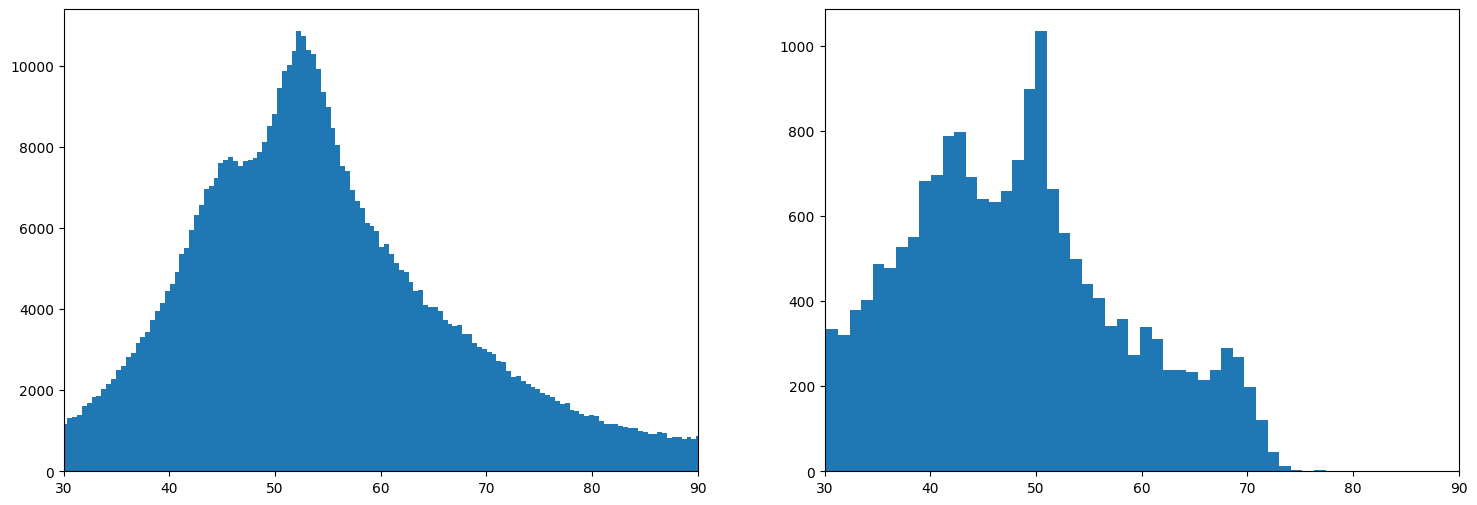

In [99]:
plt.subplots(1, 2, figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(edf.r_c, bins='auto')
plt.xlim((30, 90))
plt.subplot(1, 2, 2)
plt.hist(bdf.unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins='auto')
plt.xlim((30, 90))
plt.show()

In [100]:
event

,x_c,y_c,wv_c,r_c,x_i,y_i,t_c,z_c,true_p,beta,...,mean_rotated_r_c,dist_from_mean_rotated_r_c,rotated_r_c_sigm,beta_group,slice_counts_4_sigms,unfixed_calculated_r_2d_4_rsigms_4_tsigms,cos_theta_p,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms
subentry,,,,,,,,,,,,,,,,,,,,,
0,49.120131,-287.84,503.149606,47.261460,82.445773,-321.351895,0.042808,2000.0,801.335527,0.985169,...,50.947511,3.396695,4.193079,7.0,0.392130,45.427425,0.949598,0.982929,-0.00224,-0.227343
1,92.800131,-375.20,387.401575,54.834579,82.445773,-321.351895,-0.060419,2000.0,801.335527,0.985169,...,50.947511,6.650185,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343
2,126.400131,-308.00,453.543307,45.937552,82.445773,-321.351895,0.000390,2000.0,801.335527,0.985169,...,50.947511,5.047912,4.193079,7.0,0.302071,45.427425,0.949598,0.982929,-0.00224,-0.227343
3,45.760131,-351.68,492.125984,47.598638,82.445773,-321.351895,-0.023658,2000.0,801.335527,0.985169,...,50.947511,2.555113,4.193079,7.0,0.392130,45.427425,0.949598,0.982929,-0.00224,-0.227343
4,102.880131,-371.84,392.913386,54.466611,82.445773,-321.351895,-0.059625,2000.0,801.335527,0.985169,...,50.947511,6.249582,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343
5,96.160131,-375.20,326.771654,55.567094,82.445773,-321.351895,-0.061304,2000.0,801.335527,0.985169,...,50.947511,7.394002,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343
6,42.400131,-348.32,530.708661,48.279728,82.445773,-321.351895,-0.019260,2000.0,801.335527,0.985169,...,50.947511,2.093868,4.193079,7.0,0.257120,45.427425,0.949598,0.982929,-0.00224,-0.227343
7,89.440131,-274.40,503.149606,47.470007,82.445773,-321.351895,0.046124,2000.0,801.335527,0.985169,...,50.947511,3.061991,4.193079,7.0,0.392130,45.427425,0.949598,0.982929,-0.00224,-0.227343
8,89.440131,-375.20,387.401575,54.300455,82.445773,-321.351895,-0.059534,2000.0,801.335527,0.985169,...,50.947511,6.089170,4.193079,7.0,0.101718,45.427425,0.949598,0.982929,-0.00224,-0.227343


In [101]:
momentum_from_beta(0.985, 139.57)

796.7139544777222

In [102]:
momentum_from_beta(0.995704, 139.57)

1500.8667280793736

In [103]:
# edf.loc[30]

In [104]:
min(bdf.cos_theta_p)

0.7033225901526667

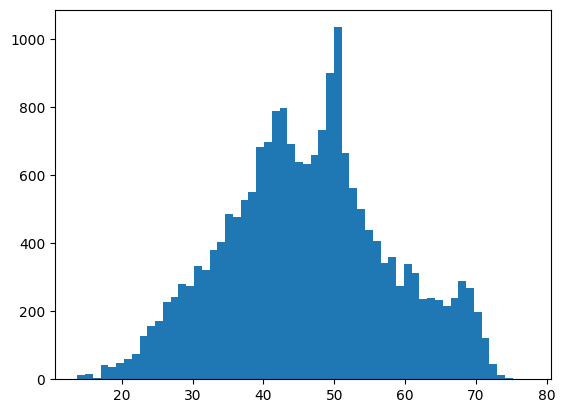

In [105]:
plt.hist(bdf.unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins='auto')
plt.show()

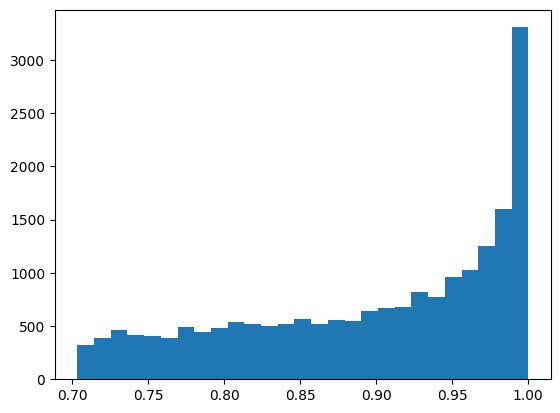

In [106]:
plt.hist(bdf.cos_theta_p, bins='auto')
plt.show()

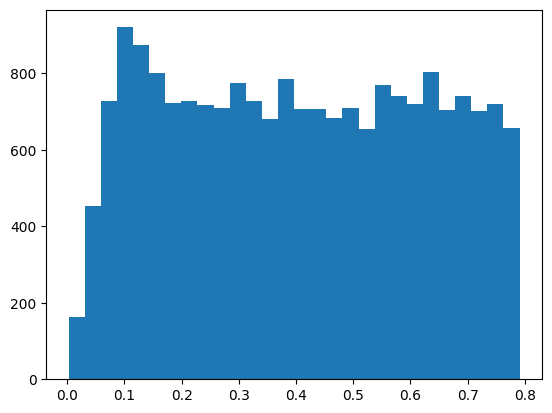

In [107]:
plt.hist(bdf.theta_p, bins='auto')
plt.show()

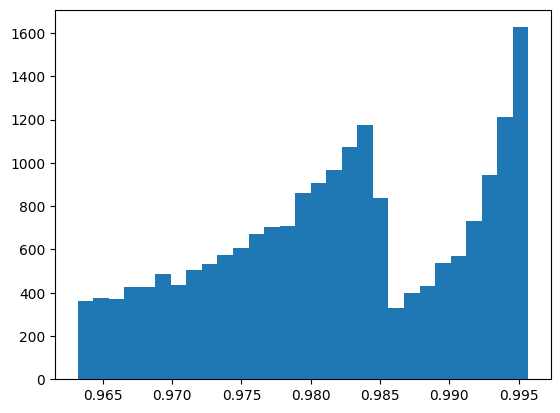

In [108]:
plt.hist(bdf.beta, bins='auto')
plt.show()

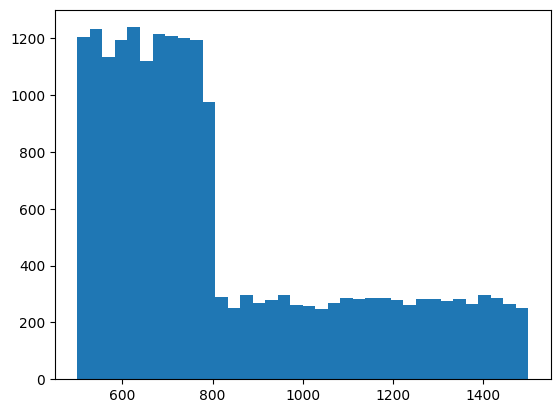

In [109]:
plt.hist(bdf.momentum, bins='auto')
plt.show()

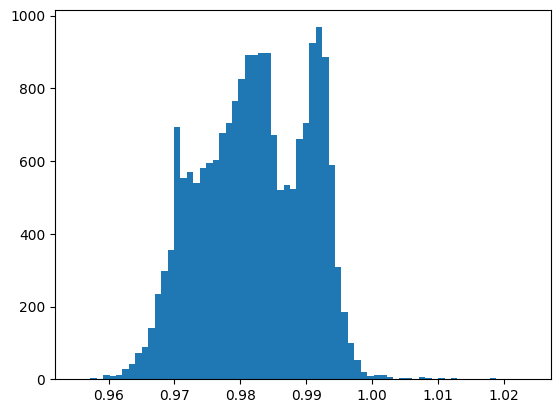

In [110]:
plt.hist(bdf.beta_from_calc_r_4_rsigms_4_tsigms, bins='auto')
plt.show()

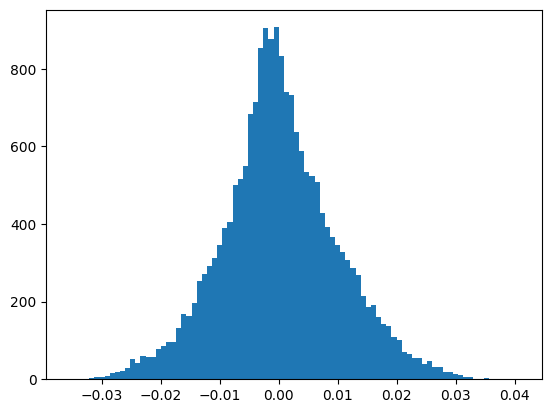

In [111]:
plt.hist(bdf.beta_from_calc_r_4_rsigms_4_tsigms - bdf.beta, bins='auto')
plt.show()

In [112]:
ф

NameError: name 'ф' is not defined

In [126]:
bdf[bdf.unfixed_calculated_r_2d_4_rsigms_4_tsigms.isna()] # All rings with intersections outside the ring itself

,r_c_mean,r_c_std,r_c_width,momentum,signal_counts,beta_group,theta_p,cos_theta_p,beta,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms


In [127]:
bdf.isna().sum()

r_c_mean                                      0
r_c_std                                      11
r_c_width                                     0
momentum                                      0
signal_counts                                 0
beta_group                                    0
theta_p                                       0
cos_theta_p                                   0
beta                                          0
unfixed_calculated_r_2d_4_rsigms_4_tsigms     0
beta_from_calc_r_4_rsigms_4_tsigms            0
delta_beta_4_rsigms_4_tsigms                  0
eps_beta_4_rsigms_4_tsigms                    0
dtype: int64

In [128]:
bdf.dropna().isna().sum()

r_c_mean                                     0
r_c_std                                      0
r_c_width                                    0
momentum                                     0
signal_counts                                0
beta_group                                   0
theta_p                                      0
cos_theta_p                                  0
beta                                         0
unfixed_calculated_r_2d_4_rsigms_4_tsigms    0
beta_from_calc_r_4_rsigms_4_tsigms           0
delta_beta_4_rsigms_4_tsigms                 0
eps_beta_4_rsigms_4_tsigms                   0
dtype: int64

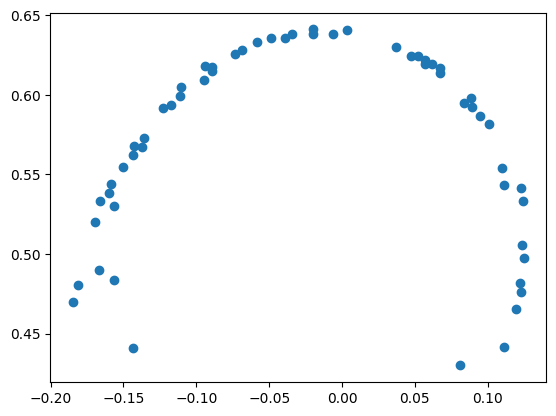

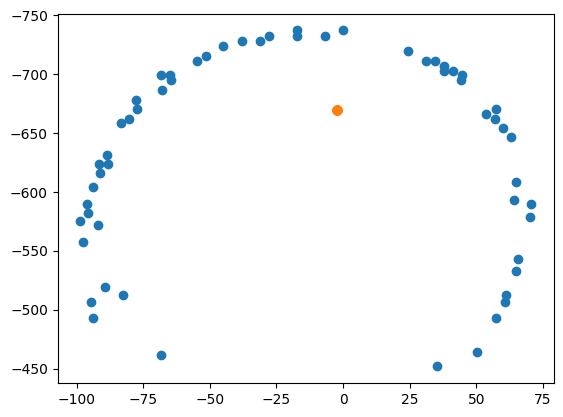

In [129]:
event = edf.loc[30]
plt.subplot()
plt.scatter(event.phi_c, event.theta_c)
plt.show()
plt.subplot()
plt.gca().invert_yaxis()
plt.scatter(event.rotated_x, event.rotated_y)
plt.scatter(event.rotated_x_i, event.rotated_y_i)
plt.show()

In [130]:
event

,x_c,y_c,wv_c,r_c,x_i,y_i,t_c,z_c,true_p,beta,...,mean_rotated_r_c,dist_from_mean_rotated_r_c,rotated_r_c_sigm,beta_group,slice_counts_4_sigms,unfixed_calculated_r_2d_4_rsigms_4_tsigms,cos_theta_p,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms
subentry,,,,,,,,,,,,,,,,,,,,,
0,-31.519869,854.56,332.283465,62.498343,3.105218,906.590243,0.132298,2000.0,1434.363165,0.995299,...,101.952975,33.132147,49.968948,10.0,0.172612,61.086293,0.742524,0.981309,-0.013991,-1.40568
1,-91.999869,988.96,508.661417,125.816352,3.105218,906.590243,-0.224134,2000.0,1434.363165,0.995299,...,101.952975,31.041298,49.968948,10.0,0.000000,61.086293,0.742524,0.981309,-0.013991,-1.40568
2,39.040131,868.00,486.614173,52.730682,3.105218,906.590243,0.093523,2000.0,1434.363165,0.995299,...,101.952975,46.345471,49.968948,10.0,0.140647,61.086293,0.742524,0.981309,-0.013991,-1.40568
3,-95.359869,972.16,403.937008,118.299478,3.105218,906.590243,-0.182098,2000.0,1434.363165,0.995299,...,101.952975,21.453290,49.968948,10.0,0.000000,61.086293,0.742524,0.981309,-0.013991,-1.40568
7,-91.999869,1039.36,354.330709,163.318052,3.105218,906.590243,-0.346803,2000.0,1434.363165,0.995299,...,101.952975,71.626993,49.968948,10.0,0.000000,61.086293,0.742524,0.981309,-0.013991,-1.40568
8,49.120131,878.08,470.078740,54.131379,3.105218,906.590243,0.065290,2000.0,1434.363165,0.995299,...,101.952975,46.839529,49.968948,10.0,0.140647,61.086293,0.742524,0.981309,-0.013991,-1.40568
9,-38.239869,857.92,354.330709,63.860855,3.105218,906.590243,0.122800,2000.0,1434.363165,0.995299,...,101.952975,32.754023,49.968948,10.0,0.172612,61.086293,0.742524,0.981309,-0.013991,-1.40568
10,-71.839869,894.88,381.889764,75.854439,3.105218,906.590243,0.020251,2000.0,1434.363165,0.995299,...,101.952975,26.135856,49.968948,10.0,0.039557,61.086293,0.742524,0.981309,-0.013991,-1.40568
11,72.640131,968.80,723.622047,93.301436,3.105218,906.590243,-0.174769,2000.0,1434.363165,0.995299,...,101.952975,0.609513,49.968948,10.0,0.000000,61.086293,0.742524,0.981309,-0.013991,-1.40568


In [156]:
def rms90(arr):
    # Calculate the mean and standard deviation of the array
    arr = arr.dropna()
    # arr_mean = np.mean(arr)
    # arr_std = np.std(arr)

    # Define the upper and lower limits for the 90% range
    lower_limit = np.percentile(arr, 5)
    upper_limit = np.percentile(arr, 95)
    # print(lower_limit, upper_limit)
    # print(arr)
    # Select the values within the 90% range
    arr_filtered = arr[(arr >= lower_limit) & (arr <= upper_limit)]
    # print(arr_filtered)
    assert arr_filtered.shape
    # Calculate the root mean square of the filtered values
    rms = np.std(arr_filtered)

    return rms

In [190]:
def betaGroupsRMS90(bdf: pd.DataFrame, avg_sigmas: tuple, avg_t_sigmas: tuple, n = 5):
  beta_sigms = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  beta_epss = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  beta_sigms_sigms = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)

  masses_mean = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  masses_upper = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  masses_lower = np.full((np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), n), 0.)
  
  for group in range(1, n + 1):
    data = bdf[bdf['beta_group'] == group]
    for i in range(np.ptp(avg_sigmas)):
      for j in range(np.ptp(avg_t_sigmas)):
        population_fourth_moment = np.mean(bdf[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'] ** 4)
        sample_fourth_moment = np.mean(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'] ** 4)
        # print(np.std(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms']))
        beta_sigms[i, j, group - 1] = rms90(data[f'delta_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'])
        # assert not np.isnan(beta_sigms[i, j, group - 1])
        beta_epss[i, j, group - 1] = rms90(data[f'eps_beta_{i + avg_sigmas[0]}_rsigms_{j + avg_t_sigmas[0]}_tsigms'])
        beta_sigms_sigms[i, j, group - 1] = np.sqrt(2 * np.abs(sample_fourth_moment - population_fourth_moment) / (data.shape[0]))
              
        masses_mean[i, j, group - 1] = np.mean((data.momentum / data.beta_from_calc_r_4_rsigms_4_tsigms * np.sqrt(1 - data.beta_from_calc_r_4_rsigms_4_tsigms ** 2)).dropna())
        masses_upper[i, j, group - 1] = np.mean((data.momentum / (data.beta_from_calc_r_4_rsigms_4_tsigms - beta_sigms[i, j, group - 1]) * np.sqrt(1 - (data.beta_from_calc_r_4_rsigms_4_tsigms - beta_sigms[i, j, group - 1]) ** 2)).dropna()) - masses_mean[i, j, group - 1] 
        masses_lower[i, j, group - 1] = masses_mean[i, j, group - 1] - np.mean((data.momentum / (data.beta_from_calc_r_4_rsigms_4_tsigms + beta_sigms[i, j, group - 1]) * np.sqrt(1 - (data.beta_from_calc_r_4_rsigms_4_tsigms + beta_sigms[i, j, group - 1]) ** 2)).dropna())


  return beta_sigms, beta_epss, beta_sigms_sigms, masses_mean, masses_upper, masses_lower

In [173]:
(bdf.momentum / bdf.beta_from_calc_r_4_rsigms_4_tsigms * np.sqrt(1 - bdf.beta_from_calc_r_4_rsigms_4_tsigms ** 2)).dropna()

Z:\Prog\FARICH\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


0        158.698782
1        141.397971
2        146.199049
3        142.692169
4        148.788589
            ...    
19788    128.858852
19789    179.923249
19790    194.682060
19791     93.022939
19792    138.426550
Length: 19655, dtype: float64

In [158]:
def plot_final_graph(beta_sigms, beta_sigms_yerr, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, to_save=True, deg_lim=False, num_of_groups=10, iteration=0):
  # labels = ['0', '1e3', '1e4', '1e5', '1e6']
  labels = ['0']
  labels = ['DCR = ' + i + ' $Hz/mm^2$' for i in labels]
  colors = ['c', 'y', 'g', 'r', 'm']
  weight = 'weighed' if weighed else 'unweighed'
  y = np.arange(1, num_of_groups + 1)
  x = (y * (max(edf['beta']) - min(edf['beta'])) - max(edf['beta']) + (num_of_groups + 1) * min(edf['beta'])) / num_of_groups

  fig, axs = plt.subplots(np.ptp(avg_sigmas), np.ptp(avg_t_sigmas), figsize=(10 * np.ptp(avg_t_sigmas), 10 * np.ptp(avg_sigmas)))
  title = f'Method: N(r) / r; {weight} Avg\nR Width = {r_width}mm, T Width = {t_width}ns\nR step factor = {r_factor}, T step factor = {t_factor}'
  if deg_lim:
    title += '\n' + r'$\theta_p < 10\deg$'
  # fig.suptitle(title)

  if np.ptp(avg_sigmas) > 1:
    for i in range(np.ptp(avg_sigmas)):
      for j in range(np.ptp(avg_t_sigmas)):
        for k in range(beta_sigms.shape[0]):
          axs[i, j].plot(x, beta_sigms[k, i, j], label=labels[k], c=colors[k])
          axs[i, j].errorbar(x, beta_sigms[k, i, j], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
          axs[i, j].errorbar(x, beta_sigms[k, i, j], yerr=beta_sigms_yerr[k, i, j], linestyle='', c=colors[k])
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlabel('Beta Group')
        axs[i, j].set_ylabel(r'RMS90($\Delta\beta$)')
        if deg_lim:
          axs[i, j].set_ylim((0, 0.004))
        axs[i, j].set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0] + i}$\sigma$\nt window width = {avg_t_sigmas[0] + j}$\sigma$')
        axs[i, j].grid()
  elif np.ptp(avg_t_sigmas) > 1:
    for j in range(np.ptp(avg_t_sigmas)):
      for k in range(beta_sigms.shape[0]):
        axs[j].plot(x, beta_sigms[k, 0, j], label=labels[k], c=colors[k])
        axs[j].errorbar(x, beta_sigms[k, 0, j], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
        axs[j].errorbar(x, beta_sigms[k, 0, j], yerr=beta_sigms_yerr[k, 0, j], linestyle='', c=colors[k])
      axs[j].legend(loc='upper right')
      axs[j].set_xlabel('Beta Group')
      axs[j].set_ylabel(r'RMS90($\Delta\beta)$')
      if deg_lim:
        axs[j].set_ylim((0, 0.004))
      axs[j].set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0]}$\sigma$\nt window width = {avg_t_sigmas[0] + j}$\sigma$')
      axs[j].grid()
  else:
    for k in range(beta_sigms.shape[0]):
      axs.plot(x, beta_sigms[k, 0, 0], label=labels[k], c=colors[k])
      axs.errorbar(x, beta_sigms[k, 0, 0], xerr=[np.diff(x)[0]/4 for _ in x], linestyle='', c=colors[k])
      axs.errorbar(x, beta_sigms[k, 0, 0], yerr=beta_sigms_yerr[k, 0, 0], linestyle='', c=colors[k])
    axs.legend(loc='upper right')
    axs.set_xlabel('Beta Group')
    axs.set_ylabel(r'RMS90($\Delta\beta$)')
    if deg_lim:
      # axs.set_ylim((0, 0.002))
        # revert back
      axs.set_ylim((0, 0.004))
        
        
        
    axs.set_title(f'Velocity resoultion for\nr window width = {avg_sigmas[0]}$\sigma$\nt window width = {avg_t_sigmas[0]}$\sigma$')
    axs.grid()

  if to_save:
    filename = f'{weight}_avg_rw={r_width}_tw={t_width}_rs={r_factor}_ts={t_factor}_rsigms={avg_sigmas[0]}-{avg_sigmas[-1]-1}_tsigms={avg_t_sigmas[0]}-{avg_t_sigmas[-1]-1}'
    if deg_lim:
      filename += '_10deg'
    filename += f'_{iteration}'
    filename += '.png'
    fig.savefig(os.path.join('results_barrel', f'{filename}'))
    plt.close(fig)
  else:
    plt.show()

In [202]:
def plot_final_mass_graph(mass_mean, mass_upper, mass_lower, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, to_save=True, deg_lim=False, num_of_groups=10, iteration=0):
    labels = ['0']
    labels = ['DCR = ' + i + ' $Hz/mm^2$' for i in labels]
    colors = ['c', 'y', 'g', 'r', 'm']
    weight = 'weighed' if weighed else 'unweighed'
    pi_mass = 139.57
    mu_mass = 105.65
    ka_mass = 493.67
    y = np.arange(1, num_of_groups + 1)
    x = (y * (max(edf['beta']) - min(edf['beta'])) - max(edf['beta']) + (num_of_groups + 1) * min(edf['beta'])) / num_of_groups
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    title = f'Method: N(r) / r; {weight} Avg\nR Width = {r_width}mm, T Width = {t_width}ns\nR step factor = {r_factor}, T step factor = {t_factor}'
    if deg_lim:
        title += '\n' + r'$\theta_p < 10\deg$'
    for k in range(mass_mean.shape[0]):
        axs.plot(x, mass_mean[k, 0], label=labels[k], c=colors[k])
        axs.errorbar(x, mass_mean[k, 0], yerr= np.array(list(zip(mass_lower[k, 0], mass_upper[k, 0]))).T, linestyle='', c=colors[k])
    
    axs.plot((min(x), max(x)), (pi_mass, pi_mass), linestyle='--', c='red')
    axs.plot((min(x), max(x)), (mu_mass, mu_mass), linestyle='--', c='red')
    # axs.plot((min(x), max(x)), (ka_mass, ka_mass), linestyle='--', c='red')

    axs.legend(loc='upper right')
    axs.set_xlabel('Beta Group')
    axs.set_ylabel(r'Measured Mass, MeV')
    axs.set_title(f'Mass resoultion for\nr window width = {avg_sigmas[0]}$\sigma$\nt window width = {avg_t_sigmas[0]}$\sigma$')
    axs.grid()
    
    if to_save:
        filename = f'{weight}_avg_rw={r_width}_tw={t_width}_rs={r_factor}_ts={t_factor}_rsigms={avg_sigmas[0]}-{avg_sigmas[-1]-1}_tsigms={avg_t_sigmas[0]}-{avg_t_sigmas[-1]-1}'
        if deg_lim:
            filename += '_10deg'
        filename += f'_{iteration}'
        filename += '.png'
        fig.savefig(os.path.join('results_barrel', f'{filename}'))
        plt.close(fig)
    else:
        plt.show()

In [192]:
bg = betaGroupsRMS90(bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms.append(bg[0])
beta_sigms_yerr.append(bg[2])

Z:\Prog\FARICH\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [193]:
bg[3]

array([[[193.35647278, 182.58523361, 172.6108985 , 164.97829195,
         155.37289123, 143.11378359, 135.81201874, 160.38139612,
         142.07346719, 121.5680762 ]]])

In [194]:
bg[4]

array([[[4.66626391, 3.71011493, 3.44557735, 3.34412435, 3.48719259,
         3.61494563, 3.76761151, 5.28429784, 5.82457977, 6.85741302]]])

In [195]:
bg[5]

array([[[4.7613496 , 3.7739309 , 3.5051012 , 3.4728543 , 3.70134167,
         3.61023268, 3.92081265, 5.45730088, 6.06177773, 7.39689986]]])

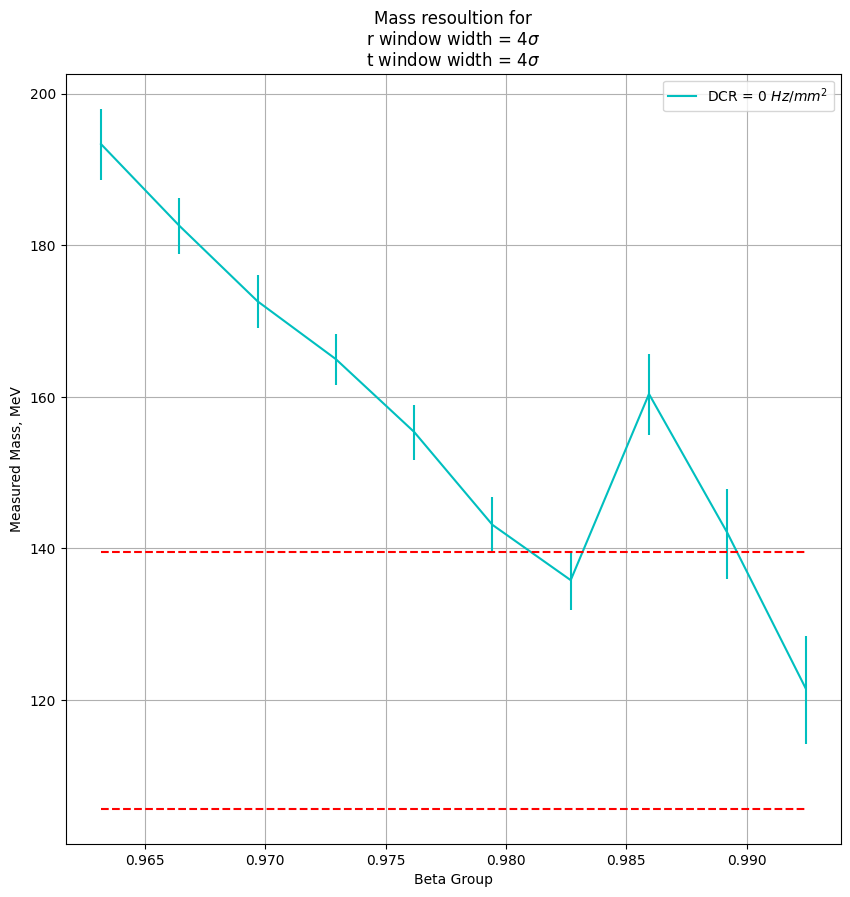

In [203]:
plot_final_mass_graph(bg[3], bg[4], bg[5], avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, to_save=False, deg_lim=False, num_of_groups=num_of_groups, iteration=0)

In [160]:
beta_sigms = np.array(beta_sigms)
beta_sigms_yerr = np.array(beta_sigms_yerr)

In [161]:
plot_final_graph(beta_sigms, beta_sigms_yerr, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, deg_lim=False, num_of_groups=num_of_groups, iteration=0)


In [162]:
edf_d = edf[edf.theta_p <= 10. * np.pi / 180]
edf_d = edf_d[edf_d.signal_counts >= 5]
bdf_d = bdf[bdf.theta_p <= 10. * np.pi / 180]
bdf_d = bdf_d[bdf_d.signal_counts >= 5]

In [163]:
bg_deglim = betaGroupsRMS90(bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms_deglim.append(bg_deglim[0])
beta_sigms_yerr_deglim.append(bg_deglim[2])

In [164]:
beta_sigms_deglim = np.array(beta_sigms_deglim)
beta_sigms_yerr_deglim = np.array(beta_sigms_yerr_deglim)

In [165]:
plot_final_graph(beta_sigms_deglim, beta_sigms_yerr_deglim, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, deg_lim=True, num_of_groups=num_of_groups, iteration=0)

In [ ]:
bdf

In [ ]:
ы

In [ ]:
plt.hist(bdf.beta, bins='auto')
plt.xlabel('beta')
plt.show()

In [ ]:
plt.subplot()
plt.hist(bdf.cos_theta_p, bins='auto')
plt.xlabel('cos_theta_p')
plt.show()
plt.subplot()
plt.hist(bdf.theta_p, bins='auto')
plt.xlabel('theta_p')
plt.show()

primary particle - last with wv = 0

In [ ]:
# coordinates[:,3]
lambdas = np.concatenate(coordinates[:,3])

In [ ]:
lambdas.shape

In [ ]:
lambdas.shape[0] / coordinates.shape[0]

In [ ]:
plt.hist(lambdas, bins=PDE_wvs)
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
# plt.xlim((200, 900))
plt.show()

In [ ]:
# delta_r = np.sqrt(x ** 2 + y ** 2 - 1000 ** 2)
plt.scatter(coordinates[0][0], coordinates[0][2], c='red', s=3)
# plt.plot(1000 * np.cos(np.linspace(0, 2*np.pi,1000)), 1000 * np.sin(np.linspace(0, 2*np.pi,1000)))
# plt.xlim((-160, 50))
# plt.ylim((-1100, -650))
plt.xlabel('X, mm')
plt.ylabel('Z, mm')
# plt.title('p = 1500 MeV' + f'\n{coordinates[0][0].shape[0]} Hits')
plt.show()

In [ ]:
print(coordinates[0][0].shape)

In [ ]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

In [ ]:
events_len = []
for i in range(coordinates.shape[0]):
    events_len.append(len(coordinates[i][0]))
events_len = np.array(events_len)
plt.hist(events_len, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Energy: 1500 MeV\nMean: {round(events_len.mean(), 1)}' + '\n' + f'Std: {round(events_len.std(), 1)}')
plt.ylabel('Events')
plt.show()

# End of main

In [ ]:
n = np.array(file_prototype['info_sim;1']['info_rad']['m_layers']['m_layers.first'].array())[0]
n
l = np.array(file_prototype['info_sim;1']['info_rad']['m_layers']['m_layers.second'].array())[0]
l
cos = 1 / n
cos
theta = np.arccos(cos)
theta
tg = np.tan(theta)
tg
2 * (tg[3] / tg[2] * (200 + l[3] / 2) - 200 - l[3])
l[3] * (1 + l[3] / 200)
l * tg

In [ ]:
d = 205
L = 35
W = 2.65 # 2.65
l_calc = np.array((-(d * (d + L) ** 3) ** (1/4) + d + L, (d * (d + L) ** 3) ** (1/4) * (-(d * (d + L) ** 3) ** (1/4) + d + L) / (d + L), (d * (d + L))  * (-(d * (d + L) ** 3) ** (1/4) + d + L) / ((d * (d + L) ** 3) ** (1/2)), -(d ** 3 + 2 * d * d * L + d * L * L - (d * (d + L) ** 3) ** (3/4)) / (d + L) ** 2))
l_calc

In [ ]:
n_calc = 1 / np.cos(np.arctan(W / l_calc))
n_calc

In [ ]:
with open(r'data\rindex.txt', 'r') as rindex:
    aerogel_1050 = np.array(list(map(lambda y: np.array([float(y[0]), float(y[1][:-2])]), list(map(lambda x: x.split('*eV '), rindex.readlines())))))
print(aerogel_1050[39])
aerogel_1040 = np.array([aerogel_1050[:, 0], aerogel_1050[:, 1] * n_calc[0] / aerogel_1050[39][1]])
aerogel_1043 = np.array([aerogel_1050[:, 0], aerogel_1050[:, 1] * n_calc[1] / aerogel_1050[39][1]])
aerogel_1047 = np.array([aerogel_1050[:, 0], aerogel_1050[:, 1] * n_calc[2] / aerogel_1050[39][1]])
aerogel_10506 = np.array([aerogel_1050[:, 0], aerogel_1050[:, 1] * n_calc[3] / aerogel_1050[39][1]])
aerogel_1040
# aerogel_10506
plt.scatter(aerogel_1050[:,0], aerogel_1050[:,1], label='aerogel_1050')
plt.scatter(aerogel_1040[0], aerogel_1040[1], label='aerogel_1040')
plt.scatter(aerogel_1043[0], aerogel_1043[1], label='aerogel_1043')
plt.scatter(aerogel_1047[0], aerogel_1047[1], label='aerogel_1047')
plt.scatter(aerogel_10506[0], aerogel_10506[1], label='aerogel_10506')
plt.xlabel('Energy, eV')
plt.ylabel('n')
plt.legend()
plt.show()

In [ ]:
text_1040 = text_1043 = text_1047 = text_10506 = ''
for i in range(aerogel_1040.shape[1]):
    text_1040 += f'    {round(aerogel_1040[0][i], 5)}*eV {round(aerogel_1040[1][i], 5)}\n'
    text_1043 += f'    {round(aerogel_1043[0][i], 5)}*eV {round(aerogel_1043[1][i], 5)}\n'
    text_1047 += f'    {round(aerogel_1047[0][i], 5)}*eV {round(aerogel_1047[1][i], 5)}\n'
    text_10506 += f'    {round(aerogel_10506[0][i], 5)}*eV {round(aerogel_10506[1][i], 5)}\n'
with open(r'data\rindex_1040.txt', 'w') as rindex:
    rindex.write(text_1040)
with open(r'data\rindex_1043.txt', 'w') as rindex:
    rindex.write(text_1043)
with open(r'data\rindex_1047.txt', 'w') as rindex:
    rindex.write(text_1047)
with open(r'data\rindex_10506.txt', 'w') as rindex:
    rindex.write(text_10506)